# Binarization and Connected Component Analysis
This notebook explains some basic image processing concepts.  We will work only on grayscale images today, because we don't need the additional complication of colors.

## Preparation

In [1]:
import matplotlib.pyplot as plt

# plots directly in the notebook
%matplotlib inline 

# make figures larger
plt.rcParams["figure.figsize"] = (10,10)

# if you have a high-dpi monitor
#%config InlineBackend.figure_format = 'retina' 

import ipywidgets as widgets


### Load and display a grayscale image

(303, 384)
float64


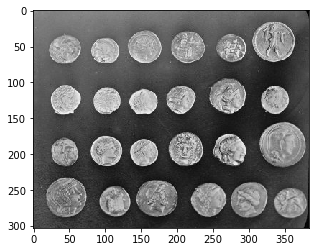

In [2]:
import numpy as np
import skimage
import skimage.data
import skimage.io
im = skimage.data.coins()
im = skimage.color.rgb2gray(im)
im = skimage.img_as_float(im) # make sure our image is floating point in range [0,1]
# to read from a file: skimage.io.imread("myimage.png")
print(im.shape)
print(im.dtype)
plt.imshow(im,cmap="gray")

## Binarizing an image
We can obtain a binary image by _thresholding_ a grayscale image.  A binary image is often called a _mask_.

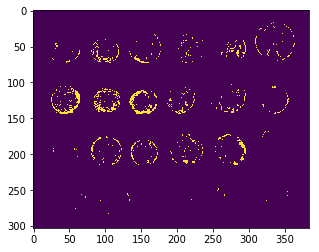

In [3]:
mask = im > 0.8 # bright pixels will be True in the mask, others will be False 
plt.imshow(mask)

Of course, the result depends on the threshold. Find a good threshold to segment this specific image.

In [4]:
@widgets.interact(threshold = (0,1,0.01))
def f(threshold):
    mask = im > threshold
    plt.imshow(mask)

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

$0.50$ sounds like a good threshold for this image, but note that the approach does not segment every coin perfectly.

## Connected Component Analysis

Separating and analyzing the "islands" of `True` pixels in a binary image is called _connected component analysis_ ([documentation](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)).

In [5]:
import skimage.measure
labels = skimage.measure.label(im > 0.5)
print(labels.shape, labels.dtype)
print("Unique values in labels:", np.unique(labels))

(303, 384) int64
Unique values in labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]


`labels` contains one different number for each "island" of `True` in `mask`, and $0$ for pixels that are `False` in mask.  These islands are called _connected components_.

In [6]:
@widgets.interact(label = list(np.unique(labels)))
def f(label):
    print(f"The connected component with label {label} contains {np.sum(labels == label)} pixels")
    plt.imshow(labels == label)

interactive(children=(Dropdown(description='label', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

The `regionprops` ([documentation](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)) function can compute properties for each connected component.  Some important properties are the following:

- `area : int` Number of pixels of the region.
- `bbox : tuple` Bounding box `(min_row, min_col, max_row, max_col)`. Pixels belonging to the bounding box are in the half-open interval `[min_row; max_row)` and `[min_col; max_col)`.
- `centroid : array` Centroid coordinate tuple `(row, col)`.
- `convex_area : int` Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.
- `label : int` The label in the labeled input image.

Let's select only the large regions

In [7]:
regions = skimage.measure.regionprops(labels)

large_regions = [r for r in regions if r.area > 100]

# equivalent to
large_regions = []
for r in regions:
    if r.area > 100:
        large_regions.append(r)

print(f"There are {len(large_regions)} large regions")

There are 25 large regions


And let's now draw all bounding boxes for the large regions over the original image

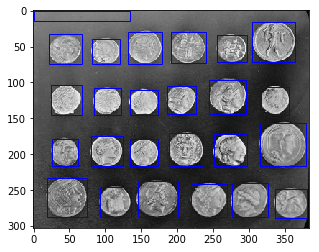

In [8]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(im, cmap="gray")
for r in large_regions:
    (min_row, min_col, max_row, max_col) = r.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row),width,height,
                             linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

## Exercises
### Exercise 1
The approach above depends on the choice of two parameters: the threshold, and the minimum size of the connected component.  Refactor the code above in order to tweak both parameters interactively and check how the results are affected by them.   Can you find a setting for which you identify all and only the coin regions?

### Solution
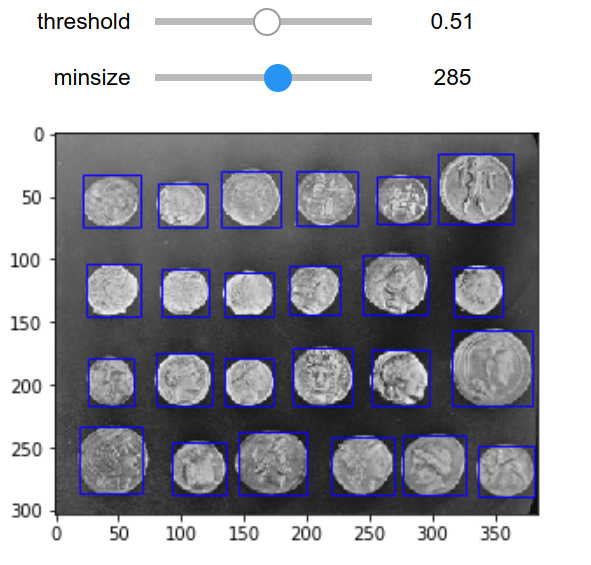

In [9]:
@widgets.interact(threshold = (0,1,0.01), minsize = (10,500))
def f(threshold, minsize):
    fig, ax = plt.subplots()
    ax.imshow(im, cmap="gray")
    
    labels = skimage.measure.label(im > threshold)
    regions = skimage.measure.regionprops(labels)
    
    large_regions = [r for r in regions if r.area > minsize]

    # equivalent to
    large_regions = []
    for r in regions:
        if r.area > minsize:
            large_regions.append(r)
    
    for r in large_regions:
        (min_row, min_col, max_row, max_col) = r.bbox
        width = max_col - min_col
        height = max_row - min_row
        rect = patches.Rectangle((min_col,min_row),width,height,
                                 linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), IntSlider(value=255…

### Exercise 2
Write a function that, given an image like the image above, crops each coin and saves it to a separate image file, named `00001.png`, `00002.png`, and so on. Use [`skimage.io.imsave(...)`](http://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imsave).

/home/lale/anaconda3/envs/deep2/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


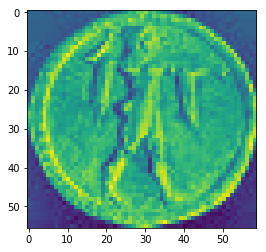

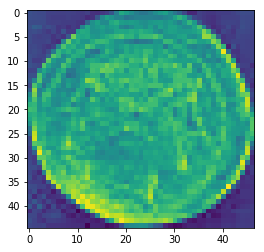

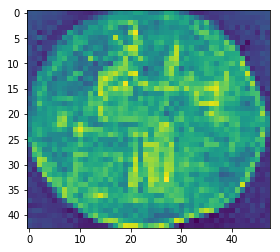

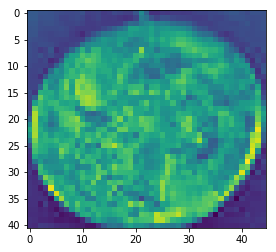

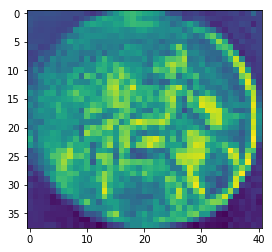

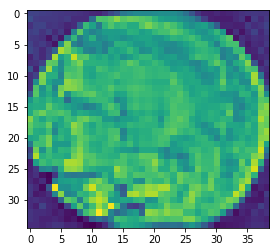

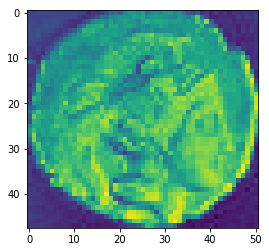

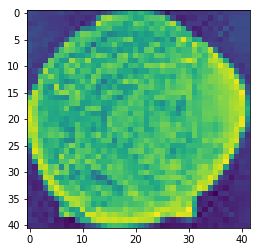

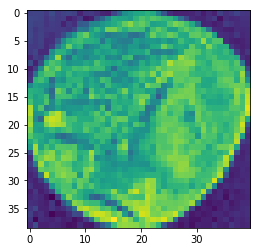

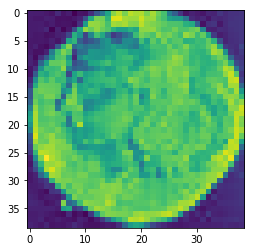

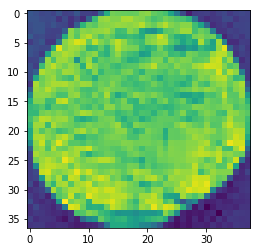

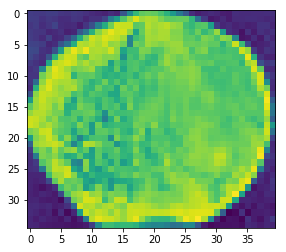

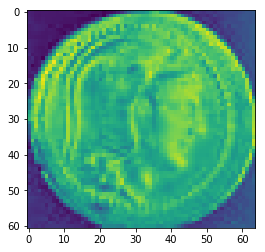

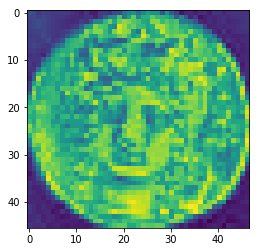

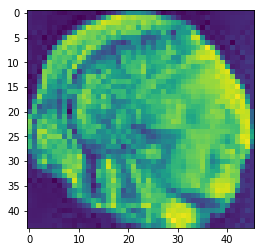

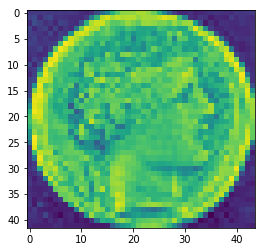

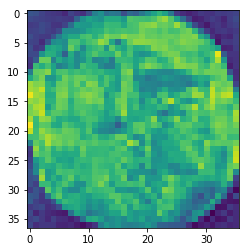

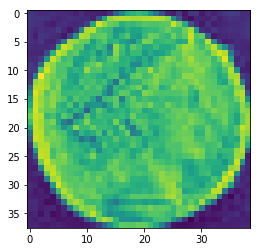

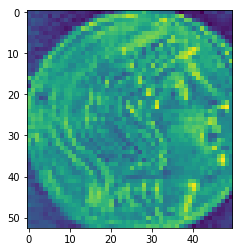

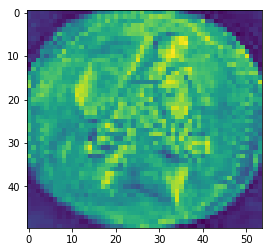

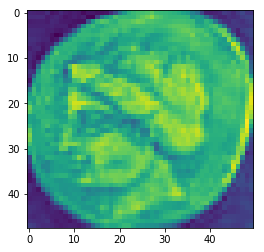

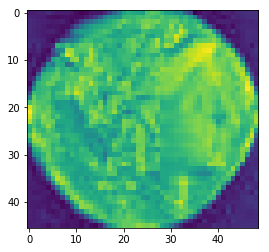

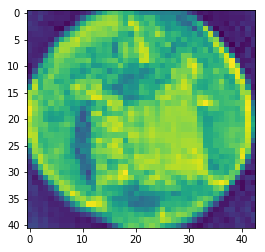

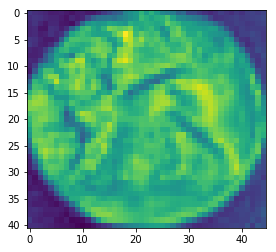

In [10]:
threshold = 0.51
minsize = 285
labels = skimage.measure.label(im > threshold)
regions = skimage.measure.regionprops(labels)
large_regions = [r for r in regions if r.area > minsize]

for i,r in enumerate(large_regions):
    (min_row, min_col, max_row, max_col) = r.bbox
    coinim = im[min_row:max_row, min_col:max_col]
    fig,ax = plt.subplots()
    ax.imshow(coinim)
    #skimage.io.imsave(f"{i:05d}.png",coinim)

### Exercise 3
Adapt your function to work on images similar to the one found at the URL below (tip: you can load it directly using `skimage.io.imread(url)`).  Note that now coins are dark on a bright background.

#### Solution
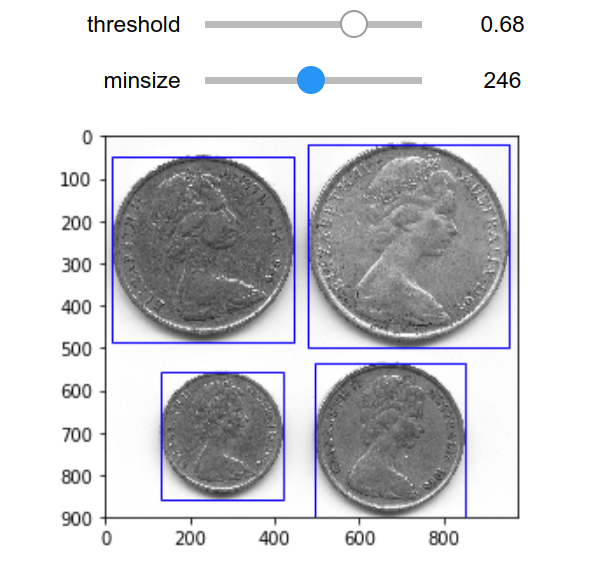

In [11]:
im = skimage.io.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Aus_coins_queen_elizabeth_1966.jpg/975px-Aus_coins_queen_elizabeth_1966.jpg")
im = skimage.img_as_float(skimage.color.rgb2gray(im))

@widgets.interact(threshold = (0,1,0.01), minsize = (10,500))
def f(threshold, minsize):
    fig, ax = plt.subplots()
    ax.imshow(im, cmap="gray")
    
    # Note LESS THAN (we are looking for dark objects)
    labels = skimage.measure.label(im < threshold) 
    regions = skimage.measure.regionprops(labels)
    
    large_regions = [r for r in regions if r.area > minsize]
    
    for r in large_regions:
        (min_row, min_col, max_row, max_col) = r.bbox
        width = max_col - min_col
        height = max_row - min_row
        rect = patches.Rectangle((min_col,min_row),width,height,
                                 linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), IntSlider(value=255…

### Exercise 4 (difficult)

Write a function to count the grains of rice in the image found at [this link](https://www.mathworks.com/help/examples/images/win64/NonuniformIlluminationExample_01.png), and return the largest and smallest grain size in pixels.

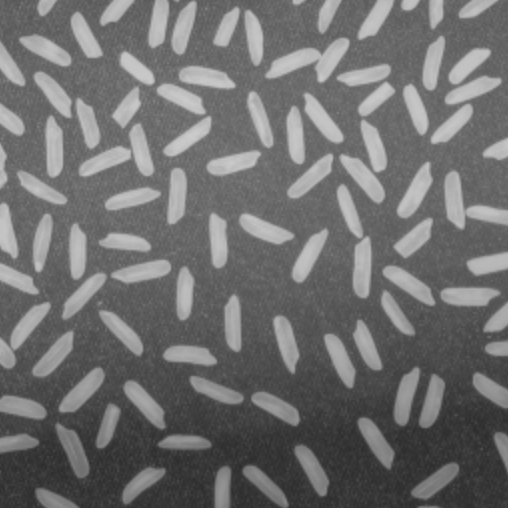

Note that thresholding is difficult due to uneven illumination (the bottom part is darker); try it!  One possible solution is to look for the darkest intensity in each row and subtract that value from all values in that row.  The code below shows an example.

### Solution (as seen in class)

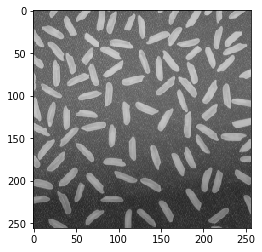

In [12]:
im = skimage.io.imread("https://carmbrustdotcom.files.wordpress.com/2016/10/rice.png")
im = skimage.img_as_float(im)
plt.imshow(im, cmap="gray", vmin=0, vmax=1)

Text(0,0.5,'minimum image intensity')

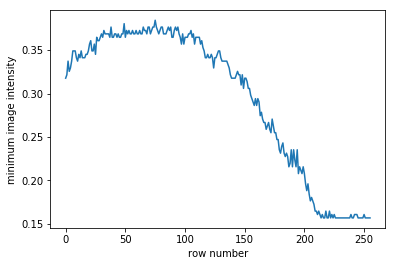

In [13]:
plt.plot(np.min(im,axis=1))
plt.xlabel("row number")
plt.ylabel("minimum image intensity")

[Text(0.5,1,'binarized')]

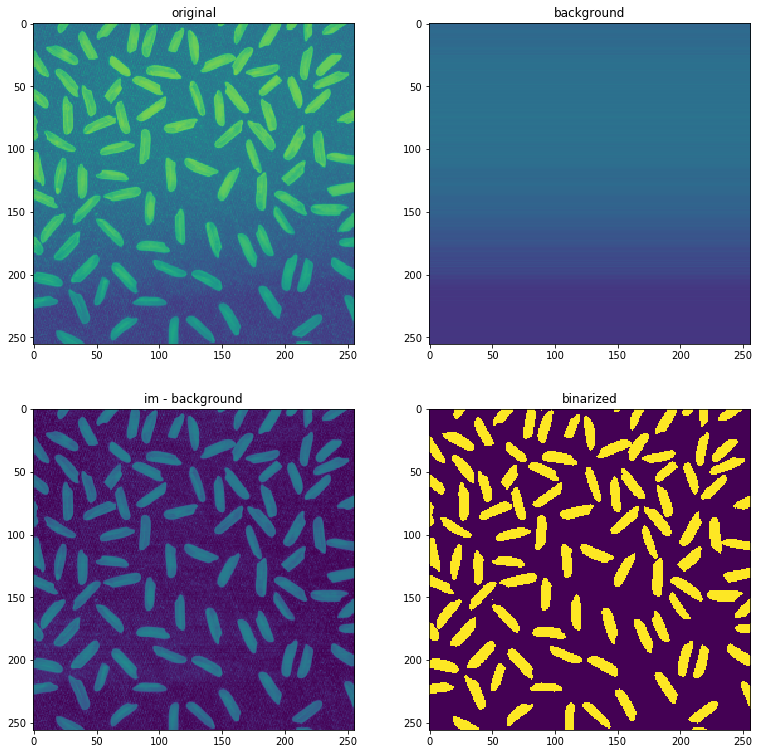

In [14]:
background = (np.min(im,axis=1,keepdims=True) * np.ones((1,im.shape[1])))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (13,13))
axs[0,0].imshow(im, vmin=0, vmax=1)
axs[0,0].set(title="original")
axs[0,1].imshow(background, vmin=0, vmax=1)
axs[0,1].set(title="background")
axs[1,0].imshow(im - background, vmin=0, vmax=1)
axs[1,0].set(title="im - background")
mask = (im - background) > 0.25
axs[1,1].imshow(mask, vmin=0, vmax=1)
axs[1,1].set(title="binarized")

97


Text(0,0.5,'number of regions')

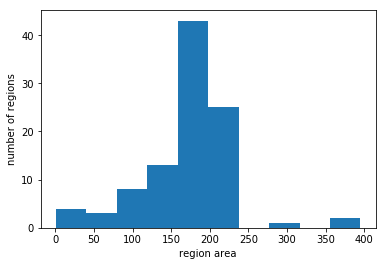

In [15]:
labels = skimage.measure.label(mask)
rp = skimage.measure.regionprops(labels)
print(len([r for r in rp if r.area > 10]))
areas = [r.area for r in rp]
plt.hist(areas);
plt.xlabel("region area")
plt.ylabel("number of regions")

[1, 4, 5, 6, 8, 9, 10, 32, 39, 40, 69, 71, 77, 90, 99]


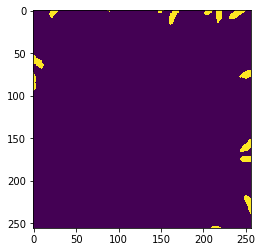

In [16]:
# plot unusually small regions
labels_smallregions = [r.label for r in rp if r.area < 120]
print(labels_smallregions)
plt.imshow(np.isin(labels, labels_smallregions))

[17, 48, 70]


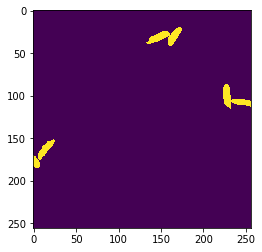

In [17]:
# plot unusually large regions
labels_largeregions = [r.label for r in rp if r.area > 250]
print(labels_largeregions)
plt.imshow(np.isin(labels, labels_largeregions))